# PPG Peak Detection without Ground‑Truth Labels

https://iopscience.iop.org/article/10.1088/1361-6579/adb89e

In [18]:
import sys
import glob
import re
import os
import math

project_root = os.path.abspath("../heart_rhythm_analysis")  # Adjust if notebook is nested deeper
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader,random_split
from torchinfo import summary

from heart_rhythm_analysis.model.unet1d import UNet1D
from heart_rhythm_analysis.utils.utils import PPGWindow,pseudo_peak_vector,scale_signal,find_sliding_window

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device:', device)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"    # avoid crashes on odd ops
torch.mps.empty_cache()                            # call between val runs

Device: mps


In [20]:
# ----------------------------- configuration -----------------------------

# H5_PATH = os.path.join('data',FOLDER_PATH,'mimic_non_af_data.h5')  # update if your file lives elsewhere
WIN_SEC = 30                      # window length in seconds
FS_ORIGINAL = 125
DEC_FACTOR = 6
FS = round(FS_ORIGINAL/DEC_FACTOR,2)                  # Hz (dataset‑wide constant)
print(FS)
WIN_LEN = int(round(WIN_SEC * FS))            # 3_750 samples
BATCH   = 32
EPOCHS  = 200                       # demo; increase to 30+ for real training

VAR_MULT=500

FOLDER_PATH = 'length_full'
DEVELOPMENT_DATA_PATH = os.path.join('..','data','development_dataset',FOLDER_PATH)
TRAIN_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'train_ds.pkl');
VAL_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'val_ds.pkl');
TEST_LOADER_PATH =os.path.join(DEVELOPMENT_DATA_PATH,'test_ds.pkl');

20.83


In [21]:
# best_config = find_sliding_window(WIN_LEN,target_windows = 5, overlap=25)
# scale_type = "norm"


# if not os.path.exists(TRAIN_LOADER_PATH):
TRAIN_PATH = f"{DEVELOPMENT_DATA_PATH}/train_datasett.h5"
train_ds = PPGWindow(TRAIN_PATH)

if not os.path.exists(DEVELOPMENT_DATA_PATH):
    os.mkdir(DEVELOPMENT_DATA_PATH)
    
torch.save(train_ds, TRAIN_LOADER_PATH)
# else:
    # train_ds = torch.load(TRAIN_LOADER_PATH, weights_only=False)

VAL_FRAC = 0.20               # 10 % of the *virtual* samples
n_total  = len(train_ds)
n_val    = int(n_total * VAL_FRAC)
n_train  = n_total - n_val

train_ds, val_ds = random_split(
    train_ds,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible
)

train_loader = DataLoader(train_ds, batch_size=BATCH,
                        shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH,
                        shuffle=True, num_workers=0, pin_memory=False)

print('Dataset ready. Example batch shapes:')
x, y,_,_= next(iter(train_loader))
print(x.shape, y.shape)   # (B, 1, 3750) (B, 3750)



Dataset ready. Example batch shapes:
torch.Size([32, 1, 625]) torch.Size([32, 625])


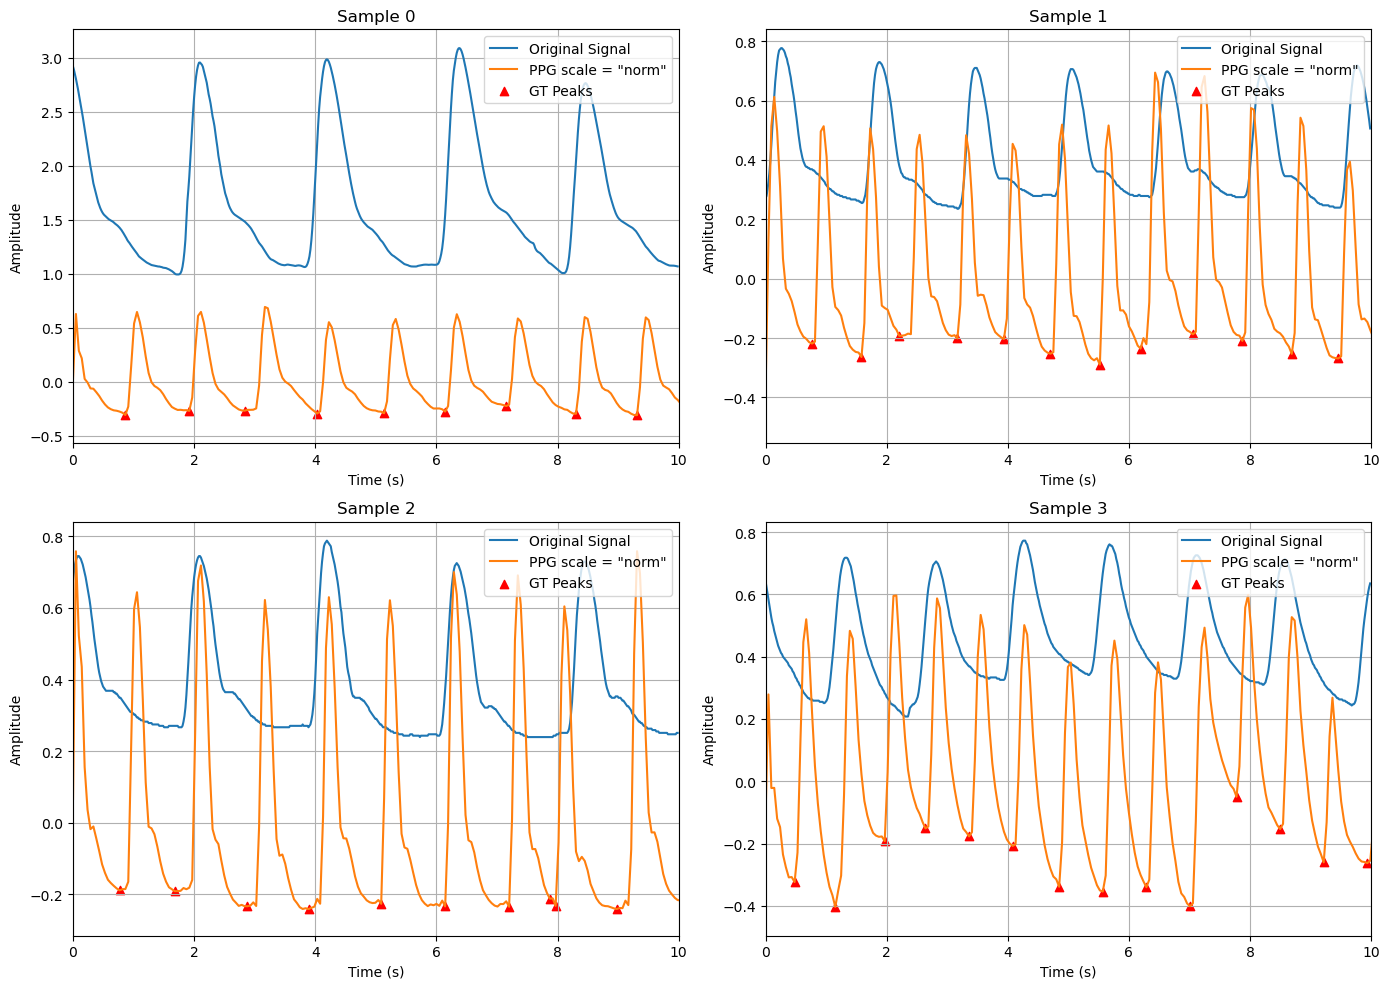

In [22]:
B, _, L = x.shape

# How many to plot
n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), squeeze=False)

for i in range(n_plot):
    x1, y1,original_signal,_ = next(iter(train_loader))
    ax = axes[i//cols][i%cols]

    x1 =x1[0][0]
    y1 = y1[0]
    original_signal = original_signal[0][0]

    peaks = np.nonzero(y1 > 0)
    t = np.arange(len(x1)) / FS
    tr = np.arange(len(x1)) / (FS_ORIGINAL/2)

    ax.plot(tr,original_signal,label='Original Signal')
    ax.plot(t, x1, label=f'PPG scale = "norm"')
    ax.scatter(t[peaks], x1[peaks], c='r', marker='^', label='GT Peaks')
    ax.set_title(f'Sample {i}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_xlim(0,10)

plt.tight_layout()
plt.show()

In [23]:
class EarlyStoppingBasic:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [24]:
# 1) Gather all labels from your training set (flattened)
counts = torch.zeros(2, dtype=torch.long)
for _, yb, _, _ in train_loader:
    flat = yb.view(-1).long()                     # ensure integer dtype
    c = torch.bincount(flat, minlength=2)         # c[0]=#zeros, c[1]=#ones
    counts += c
neg, pos = counts[0].item(), counts[1].item()
print(f"neg={neg}, pos={pos}")


alpha = 0.5
pos_weight = (neg/pos)**alpha   # ≃ 5.0

print(pos_weight)
# 3) Build your pos_weight from that ratio
pos_weight = torch.tensor([pos_weight], dtype=torch.float32, device=device)

# 4) Create your loss once, using that pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

scaler = torch.amp.GradScaler(enabled=False)       # autocast handles bfloat16

neg=1920425, pos=119575
4.007545673985783


In [25]:
model = UNet1D().to(device)
print(summary(model, input_size=(1,1, WIN_LEN)))

model = UNet1D().to(device)

LEARNING_RATE = 3e-5;
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,'min',factor=0.1,       
    patience=3,      
    threshold=1e-3,   
    threshold_mode='rel'  
)
early_stopper = EarlyStoppingBasic(patience=5, min_delta=1e-3)

# Reinforcement Learning
baseline = torch.tensor(0., device=device)
MIN_RR = 0.3
MAX_RR = 2

WINDOW_SEC   = 30
MAX_BPM      = 240
MAX_PEAKS    = int(MAX_BPM/60 * WINDOW_SEC)   # = 120
MAX_INTERVAL = MAX_PEAKS - 1                  # = 119

def compute_reward(actions,positions, fs=FS,window_sec=WINDOW_SEC,max_bpm = MAX_BPM,
                   min_rr=MIN_RR, max_rr=MAX_RR,max_interval=MAX_INTERVAL) -> float:
    # # 2) compute rewards in pure tensor ops
    # #    positions and min/max constants should be defined at module scope
    mask      = actions.to(torch.bool)                                             # (B, L)
    # mask[:,1:] * positions[1:] picks out the time of each “next” peak
    pairs = mask[:,:-1] & mask[:,1:]
    deltas = positions[1:] - positions[:-1]            # (L-1)
    reward_vals = torch.where(deltas<min_rr, -1.0,
                    torch.where(deltas>max_rr, -0.1, 1.0))
    reward_matrix = reward_vals[None] * pairs.float()  # broadcast to (B,L-1)
    raw_r            = reward_matrix.sum(dim=1)                    # (B,)
    clipped          = raw_r.clamp(-max_interval, max_interval)  # (B,)
    rewards          = clipped / max_interval                     # (B,)
    return rewards

# 2) Pretrain then anneal RL term
PRETRAIN_EPOCHS   = 10
RL_ANNEAL_EPOCHS  = 10
RL_BETA_MAX       = 0.2

baseline = torch.tensor(0., device=device)
def get_beta(epoch: int) -> float:
    if epoch <= PRETRAIN_EPOCHS:
        return 0.0
    t = min(epoch - PRETRAIN_EPOCHS, RL_ANNEAL_EPOCHS)
    return RL_BETA_MAX * (t / RL_ANNEAL_EPOCHS)

Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 625]                  --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 625]              --
│    │    └─Sequential: 3-1              [1, 16, 625]              2,544
│    └─ConvBlock: 2-2                    [1, 32, 312]              --
│    │    └─Sequential: 3-2              [1, 32, 312]              14,016
│    └─ConvBlock: 2-3                    [1, 64, 156]              --
│    │    └─Sequential: 3-3              [1, 64, 156]              55,680
│    └─ConvBlock: 2-4                    [1, 128, 78]              --
│    │    └─Sequential: 3-4              [1, 128, 78]              221,952
├─ConvBlock: 1-2                         [1, 128, 39]              --
│    └─Sequential: 2-5                   [1, 128, 39]              --
│    │    └─Conv1d: 3-5                  [1, 128, 39]              14

In [11]:
bSaveCheckPoint = True
# ─── Config ────────────────────────────────────────────────────────────────
MODEL_NUM = "conv1dnet_d0.1"
CKPT_DIR     = f"../trained_model/checkpoints/{MODEL_NUM}/"
if not os.path.exists(CKPT_DIR):
    os.mkdir(CKPT_DIR)
CKPT_PATTERN = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_*.pth")
SAVE_EVERY   = 5         # save every N epochs
RESUME       = False       # flip to False if you never want to resume
device       = "mps" if torch.backends.mps.is_available() else "cpu"

# ─── Helper: find latest checkpoint ────────────────────────────────────────
def find_latest_checkpoint(pattern=CKPT_PATTERN):
    files = glob.glob(pattern)
    if not files:
        return None
    # extract epoch number from filename
    epochs = [(int(re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f).group(1)), f)
              for f in files if re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f)]
    if not epochs:
        return None
    return max(epochs, key=lambda x: x[0])  # (epoch, filepath)

# ─── On startup: optionally resume ─────────────────────────────────────────
start_epoch = 1
if RESUME:
    latest = find_latest_checkpoint()
    if latest is not None:
        start_epoch, path = latest
        print(f"Resuming from checkpoint epoch {start_epoch}: {path}")
        ckpt = torch.load(path, map_location=device)
        print(ckpt)
        model.load_state_dict(ckpt["model"])
        optim.load_state_dict(ckpt["optim"])
        scheduler.load_state_dict(ckpt["scheduler"])
        baseline = ckpt.get("baseline", baseline)
        ckpt.get("bas")
        # if you saved RNG:
        # torch.random.set_rng_state(ckpt["rng"])
        start_epoch += 1  # next epoch to run
start_epoch

1

In [12]:
RL_START_EPOCH      = 10   # don’t do any RL until after epoch 5
RL_CALL_EPOCH_FREQ  = 3    # once you’ve started, run RL only once every 3 epochs

all_train_loss = []
all_val_loss = []
all_rl_loss = []
all_avg_rewards = []

positions = torch.arange(L, device=device, dtype=torch.float32) / FS
# ----------------------------- training ----------------------------------
# plt.figure()

for epoch in range(start_epoch, EPOCHS+1):
    model.train()
    cumulative_train_loss = 0.0
    cumulative_val_loss = 0.0
    cumulative_rl_loss = 0.0

    total_batches = 0
    epoch_reward = 0.0
    do_rl_epoch = (epoch > RL_START_EPOCH) and ((epoch - RL_START_EPOCH) % RL_CALL_EPOCH_FREQ == 0)
    beta = get_beta(epoch)
    
    for xb, yb,_,_ in tqdm(train_loader, desc=f'Train \t| Epoch {epoch}/{EPOCHS}'):
        xb, yb = xb.to(device,non_blocking=True), yb.to(device,non_blocking=True)
        optim.zero_grad(set_to_none=True) 

        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()                 # autocast returns bf16
            sup_loss   = criterion(logits, yb)
            
        rl_loss = torch.tensor(0.0, device=device)

        if  do_rl_epoch and beta > 0.0:
            # # ----------------------- Reinforcement Learning -----------------------
            probs = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
            dist = torch.distributions.Bernoulli(probs)
            actions = dist.sample()

            rewards = compute_reward(actions,positions, fs=FS,window_sec=WINDOW_SEC,max_bpm = MAX_BPM,
                   min_rr=MIN_RR, max_rr=MAX_RR,max_interval=MAX_INTERVAL)
            
            # --- build the RL loss ----------------------------------------
            logps   = dist.log_prob(actions).sum(dim=1)   # (B,)
            adv     = rewards - baseline
            rl_loss = -(logps * adv).mean()

            with torch.no_grad():
                baseline.mul_(0.9).add_(0.1 * rewards.mean())

            total_batches += 1
            epoch_reward += rewards.mean().item()
            cumulative_rl_loss += rl_loss.item() * xb.size(0)
       
        # total loss and backward 
        loss = sup_loss + beta*rl_loss
        if torch.isnan(sup_loss): raise ValueError('NaN in combines loss')

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()

        cumulative_train_loss += sup_loss.item() * xb.size(0)

    mean_rl = cumulative_rl_loss / len(train_loader.dataset)
    mean_train = cumulative_train_loss / (len(train_loader.dataset))
    avg_reward = (epoch_reward / total_batches) if total_batches > 0 else float("nan")
    all_avg_rewards.append(avg_reward)

    # ───────────────── validation ─────────────────────────────────────
    model.eval()
    with torch.no_grad():
        for xb, yb,_,_ in tqdm(val_loader, desc=f'Val \t| Epoch {epoch}/{EPOCHS}'):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.autocast("mps", dtype=torch.bfloat16):
                logits = model(xb).float()
                validation_loss   = criterion(logits, yb)
            if torch.isnan(validation_loss): raise ValueError('NaN loss')
            cumulative_val_loss += validation_loss.item() * xb.size(0)

    mean_val = cumulative_val_loss / (len(val_loader.dataset))

    # ───────────────── bookkeeping ────────────────────────────────────
    scheduler.step(mean_val)         # if ReduceLROnPlateau
    stop = early_stopper.step(mean_val)

    all_train_loss.append(mean_train)
    all_rl_loss.append(mean_rl)
    all_val_loss.append(mean_val)


    print(f"Epoch {epoch:02d} | "
          f"train = {mean_train:.4f}  | "
          f"val = {mean_val:.4f} | "
          f"beta = {beta:.4f} | "
          f"rl_loss = {mean_rl:.4f} | "
          f"avg_reward={avg_reward:.4f}  | "
          f"lr={optim.param_groups[0]['lr']:.1e}")

    # # ─── Save checkpoint every N epochs ──────────────────────────────────
    if (epoch % SAVE_EVERY == 0) and (bSaveCheckPoint):
        os.makedirs(CKPT_DIR, exist_ok=True)
        ckpt_path = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_{epoch}.pth")
        torch.save({
            "epoch":     epoch,
            "model":     model.state_dict(),
            "optim":     optim.state_dict(),
            "scheduler": scheduler.state_dict(),
            "baseline":  baseline,
            # "rng":       torch.random.get_rng_state(),
        }, ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")

    if stop:
        print("Early stopping triggered at epoch", epoch+1)
        break

    torch.mps.empty_cache() 



Train 	| Epoch 1/200: 100%|██████████| 102/102 [00:16<00:00,  6.33it/s]
Val 	| Epoch 1/200: 100%|██████████| 26/26 [00:01<00:00, 13.16it/s]


Epoch 01 | train = 0.4527  | val = 0.4490 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 2/200: 100%|██████████| 102/102 [00:15<00:00,  6.45it/s]
Val 	| Epoch 2/200: 100%|██████████| 26/26 [00:01<00:00, 18.46it/s]


Epoch 02 | train = 0.4480  | val = 0.4450 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 3/200: 100%|██████████| 102/102 [00:16<00:00,  6.32it/s]
Val 	| Epoch 3/200: 100%|██████████| 26/26 [00:01<00:00, 18.13it/s]


Epoch 03 | train = 0.4432  | val = 0.4399 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 4/200: 100%|██████████| 102/102 [00:16<00:00,  6.34it/s]
Val 	| Epoch 4/200: 100%|██████████| 26/26 [00:01<00:00, 18.27it/s]


Epoch 04 | train = 0.4386  | val = 0.4360 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 5/200: 100%|██████████| 102/102 [00:15<00:00,  6.40it/s]
Val 	| Epoch 5/200: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s]


Epoch 05 | train = 0.4341  | val = 0.4303 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_5.pth


Train 	| Epoch 6/200: 100%|██████████| 102/102 [00:16<00:00,  6.33it/s]
Val 	| Epoch 6/200: 100%|██████████| 26/26 [00:01<00:00, 17.98it/s]


Epoch 06 | train = 0.4294  | val = 0.4255 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 7/200: 100%|██████████| 102/102 [00:15<00:00,  6.38it/s]
Val 	| Epoch 7/200: 100%|██████████| 26/26 [00:01<00:00, 17.95it/s]


Epoch 07 | train = 0.4248  | val = 0.4222 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 8/200: 100%|██████████| 102/102 [00:16<00:00,  6.37it/s]
Val 	| Epoch 8/200: 100%|██████████| 26/26 [00:01<00:00, 17.76it/s]


Epoch 08 | train = 0.4201  | val = 0.4173 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 9/200: 100%|██████████| 102/102 [00:15<00:00,  6.41it/s]
Val 	| Epoch 9/200: 100%|██████████| 26/26 [00:01<00:00, 17.34it/s]


Epoch 09 | train = 0.4155  | val = 0.4116 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 10/200: 100%|██████████| 102/102 [00:15<00:00,  6.40it/s]
Val 	| Epoch 10/200: 100%|██████████| 26/26 [00:01<00:00, 17.90it/s]


Epoch 10 | train = 0.4111  | val = 0.4088 | beta = 0.0000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_10.pth


Train 	| Epoch 11/200: 100%|██████████| 102/102 [00:16<00:00,  6.37it/s]
Val 	| Epoch 11/200: 100%|██████████| 26/26 [00:01<00:00, 17.90it/s]


Epoch 11 | train = 0.4063  | val = 0.4037 | beta = 0.0200 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 12/200: 100%|██████████| 102/102 [00:15<00:00,  6.39it/s]
Val 	| Epoch 12/200: 100%|██████████| 26/26 [00:01<00:00, 17.81it/s]


Epoch 12 | train = 0.4018  | val = 0.3986 | beta = 0.0400 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 13/200: 100%|██████████| 102/102 [00:16<00:00,  6.21it/s]
Val 	| Epoch 13/200: 100%|██████████| 26/26 [00:01<00:00, 18.00it/s]


Epoch 13 | train = 0.3982  | val = 0.3958 | beta = 0.0600 | rl_loss = 1.1846 | avg_reward=-0.4740  | lr=3.0e-05


Train 	| Epoch 14/200: 100%|██████████| 102/102 [00:15<00:00,  6.39it/s]
Val 	| Epoch 14/200: 100%|██████████| 26/26 [00:01<00:00, 17.86it/s]


Epoch 14 | train = 0.3927  | val = 0.3904 | beta = 0.0800 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 15/200: 100%|██████████| 102/102 [00:16<00:00,  6.37it/s]
Val 	| Epoch 15/200: 100%|██████████| 26/26 [00:01<00:00, 17.82it/s]


Epoch 15 | train = 0.3880  | val = 0.3861 | beta = 0.1000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_15.pth


Train 	| Epoch 16/200: 100%|██████████| 102/102 [00:17<00:00,  5.95it/s]
Val 	| Epoch 16/200: 100%|██████████| 26/26 [00:01<00:00, 17.78it/s]


Epoch 16 | train = 0.3873  | val = 0.3853 | beta = 0.1200 | rl_loss = 1.3625 | avg_reward=-0.4306  | lr=3.0e-05


Train 	| Epoch 17/200: 100%|██████████| 102/102 [00:15<00:00,  6.39it/s]
Val 	| Epoch 17/200: 100%|██████████| 26/26 [00:01<00:00, 17.62it/s]


Epoch 17 | train = 0.3804  | val = 0.3773 | beta = 0.1400 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 18/200: 100%|██████████| 102/102 [00:15<00:00,  6.64it/s]
Val 	| Epoch 18/200: 100%|██████████| 26/26 [00:01<00:00, 18.76it/s]


Epoch 18 | train = 0.3749  | val = 0.3738 | beta = 0.1600 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 19/200: 100%|██████████| 102/102 [00:15<00:00,  6.49it/s]
Val 	| Epoch 19/200: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s]


Epoch 19 | train = 0.3773  | val = 0.3771 | beta = 0.1800 | rl_loss = 0.6560 | avg_reward=-0.3950  | lr=3.0e-05


Train 	| Epoch 20/200: 100%|██████████| 102/102 [00:30<00:00,  3.31it/s]
Val 	| Epoch 20/200: 100%|██████████| 26/26 [00:06<00:00,  4.15it/s]


Epoch 20 | train = 0.3693  | val = 0.3669 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_20.pth


Train 	| Epoch 21/200: 100%|██████████| 102/102 [00:30<00:00,  3.40it/s]
Val 	| Epoch 21/200: 100%|██████████| 26/26 [00:01<00:00, 18.26it/s]


Epoch 21 | train = 0.3630  | val = 0.3615 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 22/200: 100%|██████████| 102/102 [00:24<00:00,  4.09it/s]
Val 	| Epoch 22/200: 100%|██████████| 26/26 [00:01<00:00, 18.54it/s]


Epoch 22 | train = 0.3661  | val = 0.3676 | beta = 0.2000 | rl_loss = 0.1737 | avg_reward=-0.3741  | lr=3.0e-05


Train 	| Epoch 23/200: 100%|██████████| 102/102 [00:15<00:00,  6.60it/s]
Val 	| Epoch 23/200: 100%|██████████| 26/26 [00:03<00:00,  7.35it/s]


Epoch 23 | train = 0.3579  | val = 0.3555 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 24/200: 100%|██████████| 102/102 [00:20<00:00,  5.02it/s]
Val 	| Epoch 24/200: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s]


Epoch 24 | train = 0.3517  | val = 0.3501 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 25/200: 100%|██████████| 102/102 [00:22<00:00,  4.56it/s]
Val 	| Epoch 25/200: 100%|██████████| 26/26 [00:02<00:00, 12.27it/s]


Epoch 25 | train = 0.3539  | val = 0.3542 | beta = 0.2000 | rl_loss = -0.0437 | avg_reward=-0.3653  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_25.pth


Train 	| Epoch 26/200: 100%|██████████| 102/102 [00:22<00:00,  4.46it/s]
Val 	| Epoch 26/200: 100%|██████████| 26/26 [00:02<00:00, 10.84it/s]


Epoch 26 | train = 0.3470  | val = 0.3443 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 27/200: 100%|██████████| 102/102 [15:16<00:00,  8.99s/it] 
Val 	| Epoch 27/200: 100%|██████████| 26/26 [00:01<00:00, 18.59it/s]


Epoch 27 | train = 0.3412  | val = 0.3411 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 28/200: 100%|██████████| 102/102 [00:15<00:00,  6.49it/s]
Val 	| Epoch 28/200: 100%|██████████| 26/26 [00:01<00:00, 18.72it/s]


Epoch 28 | train = 0.3435  | val = 0.3449 | beta = 0.2000 | rl_loss = -0.0317 | avg_reward=-0.3468  | lr=3.0e-05


Train 	| Epoch 29/200: 100%|██████████| 102/102 [15:14<00:00,  8.97s/it]  
Val 	| Epoch 29/200: 100%|██████████| 26/26 [00:01<00:00, 18.56it/s]


Epoch 29 | train = 0.3363  | val = 0.3346 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 30/200: 100%|██████████| 102/102 [00:15<00:00,  6.65it/s]
Val 	| Epoch 30/200: 100%|██████████| 26/26 [00:01<00:00, 18.79it/s]


Epoch 30 | train = 0.3309  | val = 0.3313 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_30.pth


Train 	| Epoch 31/200: 100%|██████████| 102/102 [00:15<00:00,  6.54it/s]
Val 	| Epoch 31/200: 100%|██████████| 26/26 [00:01<00:00, 18.47it/s]


Epoch 31 | train = 0.3338  | val = 0.3340 | beta = 0.2000 | rl_loss = -0.1471 | avg_reward=-0.3331  | lr=3.0e-05


Train 	| Epoch 32/200: 100%|██████████| 102/102 [15:14<00:00,  8.97s/it]
Val 	| Epoch 32/200: 100%|██████████| 26/26 [00:01<00:00, 18.62it/s]


Epoch 32 | train = 0.3267  | val = 0.3243 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 33/200: 100%|██████████| 102/102 [00:15<00:00,  6.67it/s]
Val 	| Epoch 33/200: 100%|██████████| 26/26 [00:01<00:00, 18.90it/s]


Epoch 33 | train = 0.3214  | val = 0.3221 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 34/200: 100%|██████████| 102/102 [00:15<00:00,  6.58it/s]
Val 	| Epoch 34/200: 100%|██████████| 26/26 [00:01<00:00, 18.52it/s]


Epoch 34 | train = 0.3241  | val = 0.3275 | beta = 0.2000 | rl_loss = -0.0616 | avg_reward=-0.3221  | lr=3.0e-05


Train 	| Epoch 35/200: 100%|██████████| 102/102 [00:14<00:00,  6.85it/s]
Val 	| Epoch 35/200: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s]


Epoch 35 | train = 0.3173  | val = 0.3164 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_35.pth


Train 	| Epoch 36/200: 100%|██████████| 102/102 [00:15<00:00,  6.78it/s]
Val 	| Epoch 36/200: 100%|██████████| 26/26 [00:01<00:00, 18.82it/s]


Epoch 36 | train = 0.3121  | val = 0.3130 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 37/200: 100%|██████████| 102/102 [00:51<00:00,  1.98it/s]
Val 	| Epoch 37/200: 100%|██████████| 26/26 [00:01<00:00, 19.05it/s]


Epoch 37 | train = 0.3153  | val = 0.3187 | beta = 0.2000 | rl_loss = -0.0914 | avg_reward=-0.3097  | lr=3.0e-05


Train 	| Epoch 38/200: 100%|██████████| 102/102 [00:15<00:00,  6.69it/s]
Val 	| Epoch 38/200: 100%|██████████| 26/26 [00:01<00:00, 18.88it/s]


Epoch 38 | train = 0.3084  | val = 0.3077 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 39/200: 100%|██████████| 102/102 [00:15<00:00,  6.71it/s]
Val 	| Epoch 39/200: 100%|██████████| 26/26 [00:01<00:00, 18.92it/s]


Epoch 39 | train = 0.3032  | val = 0.3052 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 40/200: 100%|██████████| 102/102 [00:15<00:00,  6.60it/s]
Val 	| Epoch 40/200: 100%|██████████| 26/26 [00:01<00:00, 18.85it/s]


Epoch 40 | train = 0.3060  | val = 0.3110 | beta = 0.2000 | rl_loss = -0.3056 | avg_reward=-0.3016  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_40.pth


Train 	| Epoch 41/200: 100%|██████████| 102/102 [00:15<00:00,  6.71it/s]
Val 	| Epoch 41/200: 100%|██████████| 26/26 [00:01<00:00, 18.55it/s]


Epoch 41 | train = 0.2999  | val = 0.3004 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 42/200: 100%|██████████| 102/102 [00:15<00:00,  6.72it/s]
Val 	| Epoch 42/200: 100%|██████████| 26/26 [00:01<00:00, 18.44it/s]


Epoch 42 | train = 0.2947  | val = 0.2981 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 43/200: 100%|██████████| 102/102 [00:15<00:00,  6.60it/s]
Val 	| Epoch 43/200: 100%|██████████| 26/26 [00:01<00:00, 18.60it/s]


Epoch 43 | train = 0.2977  | val = 0.3026 | beta = 0.2000 | rl_loss = -0.2854 | avg_reward=-0.2898  | lr=3.0e-05


Train 	| Epoch 44/200: 100%|██████████| 102/102 [00:15<00:00,  6.70it/s]
Val 	| Epoch 44/200: 100%|██████████| 26/26 [00:01<00:00, 18.56it/s]


Epoch 44 | train = 0.2913  | val = 0.2939 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 45/200: 100%|██████████| 102/102 [00:15<00:00,  6.68it/s]
Val 	| Epoch 45/200: 100%|██████████| 26/26 [00:01<00:00, 18.42it/s]


Epoch 45 | train = 0.2866  | val = 0.2902 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_45.pth


Train 	| Epoch 46/200: 100%|██████████| 102/102 [00:15<00:00,  6.48it/s]
Val 	| Epoch 46/200: 100%|██████████| 26/26 [00:01<00:00, 18.18it/s]


Epoch 46 | train = 0.2897  | val = 0.2935 | beta = 0.2000 | rl_loss = -0.4042 | avg_reward=-0.2833  | lr=3.0e-05


Train 	| Epoch 47/200: 100%|██████████| 102/102 [00:15<00:00,  6.63it/s]
Val 	| Epoch 47/200: 100%|██████████| 26/26 [00:01<00:00, 18.21it/s]


Epoch 47 | train = 0.2834  | val = 0.2858 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 48/200: 100%|██████████| 102/102 [00:15<00:00,  6.63it/s]
Val 	| Epoch 48/200: 100%|██████████| 26/26 [00:01<00:00, 18.45it/s]


Epoch 48 | train = 0.2787  | val = 0.2841 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 49/200: 100%|██████████| 102/102 [00:15<00:00,  6.54it/s]
Val 	| Epoch 49/200: 100%|██████████| 26/26 [00:01<00:00, 18.25it/s]


Epoch 49 | train = 0.2823  | val = 0.2883 | beta = 0.2000 | rl_loss = -0.1098 | avg_reward=-0.2743  | lr=3.0e-05


Train 	| Epoch 50/200: 100%|██████████| 102/102 [00:15<00:00,  6.65it/s]
Val 	| Epoch 50/200: 100%|██████████| 26/26 [00:01<00:00, 18.24it/s]


Epoch 50 | train = 0.2761  | val = 0.2803 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_50.pth


Train 	| Epoch 51/200: 100%|██████████| 102/102 [00:15<00:00,  6.63it/s]
Val 	| Epoch 51/200: 100%|██████████| 26/26 [00:01<00:00, 19.28it/s]


Epoch 51 | train = 0.2714  | val = 0.2773 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 52/200: 100%|██████████| 102/102 [00:15<00:00,  6.55it/s]
Val 	| Epoch 52/200: 100%|██████████| 26/26 [00:01<00:00, 18.30it/s]


Epoch 52 | train = 0.2746  | val = 0.2819 | beta = 0.2000 | rl_loss = -0.3158 | avg_reward=-0.2667  | lr=3.0e-05


Train 	| Epoch 53/200: 100%|██████████| 102/102 [00:15<00:00,  6.59it/s]
Val 	| Epoch 53/200: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s]


Epoch 53 | train = 0.2686  | val = 0.2743 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 54/200: 100%|██████████| 102/102 [00:15<00:00,  6.40it/s]
Val 	| Epoch 54/200: 100%|██████████| 26/26 [00:01<00:00, 18.22it/s]


Epoch 54 | train = 0.2640  | val = 0.2718 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 55/200: 100%|██████████| 102/102 [00:15<00:00,  6.49it/s]
Val 	| Epoch 55/200: 100%|██████████| 26/26 [00:01<00:00, 18.48it/s]


Epoch 55 | train = 0.2675  | val = 0.2760 | beta = 0.2000 | rl_loss = -0.3714 | avg_reward=-0.2595  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_55.pth


Train 	| Epoch 56/200: 100%|██████████| 102/102 [00:15<00:00,  6.74it/s]
Val 	| Epoch 56/200: 100%|██████████| 26/26 [00:01<00:00, 18.68it/s]


Epoch 56 | train = 0.2619  | val = 0.2682 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 57/200: 100%|██████████| 102/102 [00:15<00:00,  6.75it/s]
Val 	| Epoch 57/200: 100%|██████████| 26/26 [00:01<00:00, 18.61it/s]


Epoch 57 | train = 0.2571  | val = 0.2659 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 58/200: 100%|██████████| 102/102 [00:15<00:00,  6.47it/s]
Val 	| Epoch 58/200: 100%|██████████| 26/26 [00:01<00:00, 18.38it/s]


Epoch 58 | train = 0.2603  | val = 0.2709 | beta = 0.2000 | rl_loss = -0.3939 | avg_reward=-0.2566  | lr=3.0e-05


Train 	| Epoch 59/200: 100%|██████████| 102/102 [00:15<00:00,  6.65it/s]
Val 	| Epoch 59/200: 100%|██████████| 26/26 [00:01<00:00, 18.44it/s]


Epoch 59 | train = 0.2550  | val = 0.2623 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 60/200: 100%|██████████| 102/102 [00:15<00:00,  6.63it/s]
Val 	| Epoch 60/200: 100%|██████████| 26/26 [00:01<00:00, 18.39it/s]


Epoch 60 | train = 0.2504  | val = 0.2612 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_60.pth


Train 	| Epoch 61/200: 100%|██████████| 102/102 [00:51<00:00,  1.98it/s]
Val 	| Epoch 61/200: 100%|██████████| 26/26 [00:01<00:00, 18.61it/s]


Epoch 61 | train = 0.2539  | val = 0.2661 | beta = 0.2000 | rl_loss = -0.3541 | avg_reward=-0.2468  | lr=3.0e-05


Train 	| Epoch 62/200: 100%|██████████| 102/102 [00:15<00:00,  6.72it/s]
Val 	| Epoch 62/200: 100%|██████████| 26/26 [00:01<00:00, 18.61it/s]


Epoch 62 | train = 0.2484  | val = 0.2583 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 63/200: 100%|██████████| 102/102 [00:15<00:00,  6.67it/s]
Val 	| Epoch 63/200: 100%|██████████| 26/26 [00:01<00:00, 18.72it/s]


Epoch 63 | train = 0.2439  | val = 0.2564 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 64/200: 100%|██████████| 102/102 [15:14<00:00,  8.97s/it]  
Val 	| Epoch 64/200: 100%|██████████| 26/26 [00:01<00:00, 18.82it/s]


Epoch 64 | train = 0.2479  | val = 0.2625 | beta = 0.2000 | rl_loss = -0.3266 | avg_reward=-0.2406  | lr=3.0e-05


Train 	| Epoch 65/200: 100%|██████████| 102/102 [00:14<00:00,  6.85it/s]
Val 	| Epoch 65/200: 100%|██████████| 26/26 [00:01<00:00, 19.02it/s]


Epoch 65 | train = 0.2419  | val = 0.2523 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_65.pth


Train 	| Epoch 66/200: 100%|██████████| 102/102 [00:14<00:00,  6.86it/s]
Val 	| Epoch 66/200: 100%|██████████| 26/26 [00:01<00:00, 18.95it/s]


Epoch 66 | train = 0.2373  | val = 0.2519 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 67/200: 100%|██████████| 102/102 [00:15<00:00,  6.72it/s]
Val 	| Epoch 67/200: 100%|██████████| 26/26 [00:01<00:00, 18.85it/s]


Epoch 67 | train = 0.2418  | val = 0.2558 | beta = 0.2000 | rl_loss = -0.5609 | avg_reward=-0.2352  | lr=3.0e-05


Train 	| Epoch 68/200: 100%|██████████| 102/102 [00:14<00:00,  6.89it/s]
Val 	| Epoch 68/200: 100%|██████████| 26/26 [00:01<00:00, 18.94it/s]


Epoch 68 | train = 0.2359  | val = 0.2481 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 69/200: 100%|██████████| 102/102 [00:14<00:00,  6.88it/s]
Val 	| Epoch 69/200: 100%|██████████| 26/26 [00:01<00:00, 18.82it/s]


Epoch 69 | train = 0.2313  | val = 0.2466 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 70/200: 100%|██████████| 102/102 [00:15<00:00,  6.67it/s]
Val 	| Epoch 70/200: 100%|██████████| 26/26 [00:01<00:00, 18.75it/s]


Epoch 70 | train = 0.2355  | val = 0.2535 | beta = 0.2000 | rl_loss = -0.4584 | avg_reward=-0.2338  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_70.pth


Train 	| Epoch 71/200: 100%|██████████| 102/102 [00:14<00:00,  6.82it/s]
Val 	| Epoch 71/200: 100%|██████████| 26/26 [00:01<00:00, 18.83it/s]


Epoch 71 | train = 0.2304  | val = 0.2453 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 72/200: 100%|██████████| 102/102 [00:15<00:00,  6.80it/s]
Val 	| Epoch 72/200: 100%|██████████| 26/26 [00:01<00:00, 18.73it/s]


Epoch 72 | train = 0.2255  | val = 0.2436 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 73/200: 100%|██████████| 102/102 [00:15<00:00,  6.66it/s]
Val 	| Epoch 73/200: 100%|██████████| 26/26 [00:01<00:00, 18.57it/s]


Epoch 73 | train = 0.2296  | val = 0.2473 | beta = 0.2000 | rl_loss = -0.5428 | avg_reward=-0.2280  | lr=3.0e-05


Train 	| Epoch 74/200: 100%|██████████| 102/102 [00:14<00:00,  6.80it/s]
Val 	| Epoch 74/200: 100%|██████████| 26/26 [00:01<00:00, 18.74it/s]


Epoch 74 | train = 0.2244  | val = 0.2418 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 75/200: 100%|██████████| 102/102 [15:13<00:00,  8.96s/it]  
Val 	| Epoch 75/200: 100%|██████████| 26/26 [00:01<00:00, 18.63it/s]


Epoch 75 | train = 0.2198  | val = 0.2392 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_75.pth


Train 	| Epoch 76/200: 100%|██████████| 102/102 [00:15<00:00,  6.58it/s]
Val 	| Epoch 76/200: 100%|██████████| 26/26 [00:01<00:00, 18.85it/s]


Epoch 76 | train = 0.2244  | val = 0.2448 | beta = 0.2000 | rl_loss = -0.5139 | avg_reward=-0.2214  | lr=3.0e-05


Train 	| Epoch 77/200: 100%|██████████| 102/102 [00:15<00:00,  6.68it/s]
Val 	| Epoch 77/200: 100%|██████████| 26/26 [00:01<00:00, 19.00it/s]


Epoch 77 | train = 0.2187  | val = 0.2374 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 78/200: 100%|██████████| 102/102 [08:26<00:00,  4.96s/it]  
Val 	| Epoch 78/200: 100%|██████████| 26/26 [00:01<00:00, 18.83it/s]


Epoch 78 | train = 0.2142  | val = 0.2363 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 79/200: 100%|██████████| 102/102 [00:15<00:00,  6.65it/s]
Val 	| Epoch 79/200: 100%|██████████| 26/26 [00:01<00:00, 19.14it/s]


Epoch 79 | train = 0.2184  | val = 0.2398 | beta = 0.2000 | rl_loss = -0.4687 | avg_reward=-0.2163  | lr=3.0e-05


Train 	| Epoch 80/200: 100%|██████████| 102/102 [00:14<00:00,  6.82it/s]
Val 	| Epoch 80/200: 100%|██████████| 26/26 [00:01<00:00, 19.03it/s]


Epoch 80 | train = 0.2130  | val = 0.2336 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_80.pth


Train 	| Epoch 81/200: 100%|██████████| 102/102 [00:14<00:00,  6.82it/s]
Val 	| Epoch 81/200: 100%|██████████| 26/26 [00:01<00:00, 19.17it/s]


Epoch 81 | train = 0.2086  | val = 0.2325 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 82/200: 100%|██████████| 102/102 [00:15<00:00,  6.66it/s]
Val 	| Epoch 82/200: 100%|██████████| 26/26 [00:01<00:00, 18.36it/s]


Epoch 82 | train = 0.2132  | val = 0.2364 | beta = 0.2000 | rl_loss = -0.5433 | avg_reward=-0.2128  | lr=3.0e-05


Train 	| Epoch 83/200: 100%|██████████| 102/102 [00:15<00:00,  6.79it/s]
Val 	| Epoch 83/200: 100%|██████████| 26/26 [00:01<00:00, 18.83it/s]


Epoch 83 | train = 0.2078  | val = 0.2309 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 84/200: 100%|██████████| 102/102 [00:14<00:00,  6.84it/s]
Val 	| Epoch 84/200: 100%|██████████| 26/26 [00:01<00:00, 18.79it/s]


Epoch 84 | train = 0.2032  | val = 0.2294 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 85/200: 100%|██████████| 102/102 [00:15<00:00,  6.66it/s]
Val 	| Epoch 85/200: 100%|██████████| 26/26 [00:01<00:00, 18.66it/s]


Epoch 85 | train = 0.2079  | val = 0.2329 | beta = 0.2000 | rl_loss = -0.4181 | avg_reward=-0.2119  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_85.pth


Train 	| Epoch 86/200: 100%|██████████| 102/102 [00:14<00:00,  6.82it/s]
Val 	| Epoch 86/200: 100%|██████████| 26/26 [00:01<00:00, 19.00it/s]


Epoch 86 | train = 0.2027  | val = 0.2280 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 87/200: 100%|██████████| 102/102 [00:14<00:00,  6.81it/s]
Val 	| Epoch 87/200: 100%|██████████| 26/26 [00:01<00:00, 18.84it/s]


Epoch 87 | train = 0.1983  | val = 0.2277 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 88/200: 100%|██████████| 102/102 [00:15<00:00,  6.66it/s]
Val 	| Epoch 88/200: 100%|██████████| 26/26 [00:01<00:00, 18.95it/s]


Epoch 88 | train = 0.2030  | val = 0.2354 | beta = 0.2000 | rl_loss = -0.6047 | avg_reward=-0.2046  | lr=3.0e-05


Train 	| Epoch 89/200: 100%|██████████| 102/102 [00:15<00:00,  6.79it/s]
Val 	| Epoch 89/200: 100%|██████████| 26/26 [00:01<00:00, 18.78it/s]


Epoch 89 | train = 0.1979  | val = 0.2245 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 90/200: 100%|██████████| 102/102 [00:15<00:00,  6.79it/s]
Val 	| Epoch 90/200: 100%|██████████| 26/26 [00:01<00:00, 18.81it/s]


Epoch 90 | train = 0.1934  | val = 0.2241 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_90.pth


Train 	| Epoch 91/200: 100%|██████████| 102/102 [00:15<00:00,  6.65it/s]
Val 	| Epoch 91/200: 100%|██████████| 26/26 [00:01<00:00, 18.68it/s]


Epoch 91 | train = 0.1978  | val = 0.2304 | beta = 0.2000 | rl_loss = -0.4273 | avg_reward=-0.2023  | lr=3.0e-05


Train 	| Epoch 92/200: 100%|██████████| 102/102 [00:15<00:00,  6.78it/s]
Val 	| Epoch 92/200: 100%|██████████| 26/26 [00:01<00:00, 18.54it/s]


Epoch 92 | train = 0.1932  | val = 0.2227 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 93/200: 100%|██████████| 102/102 [00:15<00:00,  6.77it/s]
Val 	| Epoch 93/200: 100%|██████████| 26/26 [00:01<00:00, 18.81it/s]


Epoch 93 | train = 0.1886  | val = 0.2218 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 94/200: 100%|██████████| 102/102 [00:15<00:00,  6.63it/s]
Val 	| Epoch 94/200: 100%|██████████| 26/26 [00:01<00:00, 18.85it/s]


Epoch 94 | train = 0.1928  | val = 0.2268 | beta = 0.2000 | rl_loss = -0.6429 | avg_reward=-0.2010  | lr=3.0e-05


Train 	| Epoch 95/200: 100%|██████████| 102/102 [00:15<00:00,  6.77it/s]
Val 	| Epoch 95/200: 100%|██████████| 26/26 [00:01<00:00, 18.79it/s]


Epoch 95 | train = 0.1885  | val = 0.2203 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_95.pth


Train 	| Epoch 96/200: 100%|██████████| 102/102 [00:15<00:00,  6.74it/s]
Val 	| Epoch 96/200: 100%|██████████| 26/26 [00:01<00:00, 18.69it/s]


Epoch 96 | train = 0.1841  | val = 0.2211 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 97/200: 100%|██████████| 102/102 [00:15<00:00,  6.59it/s]
Val 	| Epoch 97/200: 100%|██████████| 26/26 [00:01<00:00, 18.27it/s]


Epoch 97 | train = 0.1880  | val = 0.2239 | beta = 0.2000 | rl_loss = -0.5607 | avg_reward=-0.1986  | lr=3.0e-05


Train 	| Epoch 98/200: 100%|██████████| 102/102 [00:15<00:00,  6.69it/s]
Val 	| Epoch 98/200: 100%|██████████| 26/26 [00:01<00:00, 18.61it/s]


Epoch 98 | train = 0.1838  | val = 0.2183 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 99/200: 100%|██████████| 102/102 [00:15<00:00,  6.71it/s]
Val 	| Epoch 99/200: 100%|██████████| 26/26 [00:01<00:00, 18.61it/s]


Epoch 99 | train = 0.1796  | val = 0.2177 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 100/200: 100%|██████████| 102/102 [00:15<00:00,  6.62it/s]
Val 	| Epoch 100/200: 100%|██████████| 26/26 [00:01<00:00, 18.66it/s]


Epoch 100 | train = 0.1838  | val = 0.2273 | beta = 0.2000 | rl_loss = -0.4346 | avg_reward=-0.1959  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_100.pth


Train 	| Epoch 101/200: 100%|██████████| 102/102 [00:15<00:00,  6.71it/s]
Val 	| Epoch 101/200: 100%|██████████| 26/26 [00:01<00:00, 18.73it/s]


Epoch 101 | train = 0.1797  | val = 0.2155 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 102/200: 100%|██████████| 102/102 [00:15<00:00,  6.68it/s]
Val 	| Epoch 102/200: 100%|██████████| 26/26 [00:01<00:00, 18.44it/s]


Epoch 102 | train = 0.1755  | val = 0.2164 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 103/200: 100%|██████████| 102/102 [00:15<00:00,  6.59it/s]
Val 	| Epoch 103/200: 100%|██████████| 26/26 [00:01<00:00, 18.75it/s]


Epoch 103 | train = 0.1797  | val = 0.2210 | beta = 0.2000 | rl_loss = -0.6652 | avg_reward=-0.1949  | lr=3.0e-05


Train 	| Epoch 104/200: 100%|██████████| 102/102 [00:15<00:00,  6.75it/s]
Val 	| Epoch 104/200: 100%|██████████| 26/26 [00:01<00:00, 18.53it/s]


Epoch 104 | train = 0.1754  | val = 0.2167 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05


Train 	| Epoch 105/200: 100%|██████████| 102/102 [00:15<00:00,  6.74it/s]
Val 	| Epoch 105/200: 100%|██████████| 26/26 [00:01<00:00, 18.72it/s]


Epoch 105 | train = 0.1712  | val = 0.2149 | beta = 0.2000 | rl_loss = 0.0000 | avg_reward=nan  | lr=3.0e-05
Saved checkpoint: ../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_105.pth


Train 	| Epoch 106/200: 100%|██████████| 102/102 [00:15<00:00,  6.61it/s]
Val 	| Epoch 106/200: 100%|██████████| 26/26 [00:01<00:00, 18.68it/s]

Epoch 106 | train = 0.1752  | val = 0.2198 | beta = 0.2000 | rl_loss = -0.5746 | avg_reward=-0.1965  | lr=3.0e-05
Early stopping triggered at epoch 107


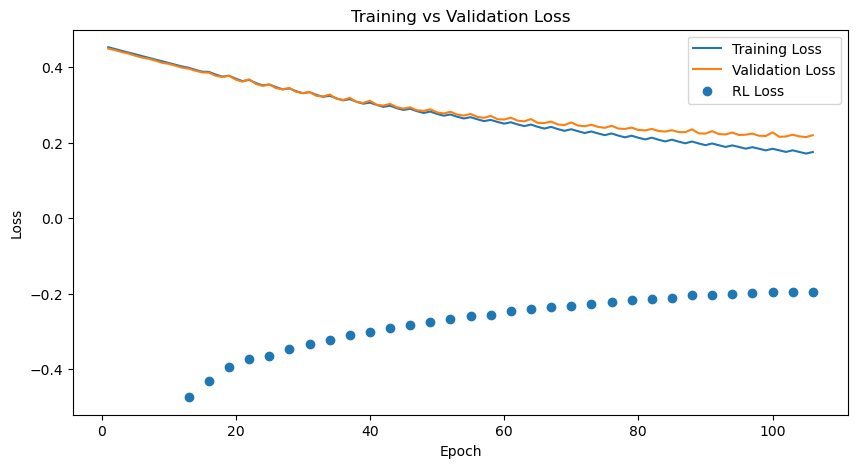

In [13]:

epochs = range(1, len(all_train_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, all_train_loss, label='Training Loss')
plt.plot(epochs, all_val_loss, label='Validation Loss')
plt.scatter(range(start_epoch, start_epoch+len(all_avg_rewards)), all_avg_rewards, label='RL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [14]:
import datetime

tz = datetime.timezone.utc
ft = "%Y_%m_%d_%H_%M_%S_%z"
t = datetime.datetime.now(tz=tz).strftime(ft)
# print(t)

CKPT_FILE_NAME = f'PPG_PEAK_DETECTION_MODEL_{epoch}_{t}.pth'
CKPT_FILE = os.path.join('../trained_model',CKPT_FILE_NAME)
print(CKPT_FILE)
# save weights
torch.save(model.state_dict(), CKPT_FILE)
print('Checkpoint saved.')


../trained_model/PPG_PEAK_DETECTION_MODEL_106_2025_04_30_17_25_18_+0000.pth
Checkpoint saved.


In [6]:
FOLDER_PATH = 'length_full'
TEST_PATH = os.path.join('../data','development_dataset',FOLDER_PATH,'test_datasett.h5')  # update if your file lives elsewhere

CKPT     = os.path.join('../trained_model/checkpoints/conv1dnet_d0.1/ckpt_epoch_conv1dnet_d0.1_105.pth')
# if not os.path.exists(TEST_LOADER_PATH):
test_ds = PPGWindow(TEST_PATH)
torch.save(test_ds,TEST_LOADER_PATH)
# else:
    # test_ds = torch.load(TEST_LOADER_PATH,weights_only=False)

test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)

# ------------ load the trained model -------------------------------------
model  = UNet1D().to(device)
ckpt = torch.load(CKPT, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()



UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Co

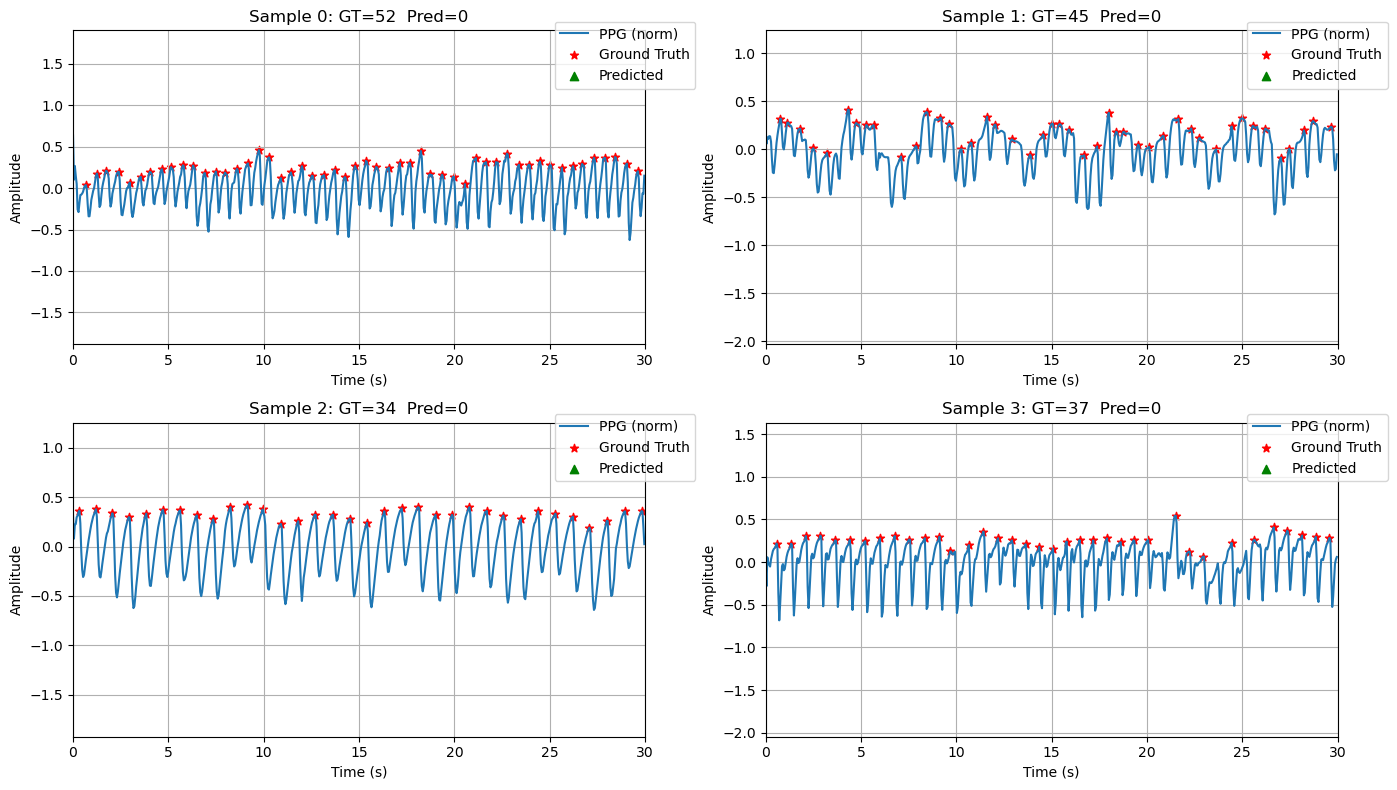

In [30]:
THRESH   = 0.8        # probability cut‑off for “peak”
xb, yb, orig,_ = next(iter(test_loader))     # xb: (B,1,L), yb: (B,L), orig:(B,1,L)
xb, yb, orig = xb.to(device), yb.to(device), orig  # orig can stay on CPU

yb_cpu = yb.cpu().numpy()          # shape (B, L)

B, _, L = xb.shape
t = np.arange(L) / FS 

n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)


for i in range(n_plot):
    ax = axes[i//cols][i%cols]
    original_window = orig[i,0].numpy()   # shape (L,)
    original_window = -original_window

    window_norm = xb[i,0].cpu().numpy()   # shape (L,)
    window_norm = -window_norm

    inp  = xb[i:i+1].to(device)            # shape (1,1,L)
    with torch.no_grad():
        prob = torch.sigmoid(model(inp))[0]  # shape (L,)
    prob_np    = prob.cpu().numpy()
    peaks_pred = np.where(prob_np > THRESH)[0]

    # 4) ground‑truth peaks from yb
    gt_peaks = np.where(yb_cpu[i] > 0)[0]
    # 5) now plot
    ax.plot(t, window_norm,label='PPG (norm)', linestyle='-')
    ax.scatter(t[gt_peaks], window_norm[gt_peaks],
               c='r', marker='*', label='Ground Truth')
    ax.scatter(t[peaks_pred], window_norm[peaks_pred],
               c='g', marker='^', label='Predicted')


    ax.set_title(f"Sample {i}: GT={len(gt_peaks)}  Pred={len(peaks_pred)}")
    ax.set_xlim(0, WIN_SEC)
    ax.set_ylim(np.min(window_norm)*3, np.max(window_norm)*3)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1.05))
    ax.grid()


    # ax1.hist(np.diff(t[peaks_pred]))

plt.tight_layout()
plt.show()

In [8]:

print('Ground Truth Peak Positions: \t', gt_peaks)
print('Predicted Peaks Positions: \t', peaks_pred)
print(len(gt_peaks[1:] - gt_peaks[:-1]))
print(len(peaks_pred[1:] - peaks_pred[:-1]))


Ground Truth Peak Positions: 	 [ 18  32  47  62  78  92 108 122 138 153 167 182 197 211 226 241 255 269
 284 298 312 327 343 358 373 389 405 420 436 451 465 481 504 517 527 559
 578 608]
Predicted Peaks Positions: 	 [ 18  32  47  62  78  93 108 123 153 167 197 211 241 255 269 283 297 327
 343 357 373 389 405 421 436 451 465 481 527 579 607 608]
37
31


In [27]:
model.eval()
all_test_loss = [];
cumulative_test_loss = 0.0
with torch.no_grad():
    for xb, yb,_,_ in tqdm(test_loader, desc=f'Test\t'):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()
            test_loss   = criterion(logits, yb)
        if torch.isnan(test_loss): raise ValueError('NaN loss')
        cumulative_test_loss += test_loss.item() * xb.size(0)

mean_val = cumulative_test_loss / (len(test_loader.dataset))
all_test_loss.append(mean_val)

Test	: 100%|██████████| 32/32 [00:02<00:00, 15.75it/s]


In [28]:
print(all_test_loss)

[0.8367371848985261]
